# Predicting daily users of Bixi Montreal

## Sections

1. Objectives
2. Setting up the notebook and querying the data.
3. Light data exploration 
4. Data cleaning
5. Data exploration
6. Model building
7. Conclusion

## 1. Objectives

[Bixi](https://bixi.com/en) is Montreal's public bike share program. It has been in service since 2014 and now has close to 800 stations with close to 10000 bikes in the network. A team of drivers and technicians has to manually move bicycles from filled stations to empty ones. For this reason, predicting the amount of daily uses could help with scheduling employees and in turn, save money.

**Disclaimer:** This is my first data science project. Every tool and technique used in this project is new to me. I have decided not to use an existing similar project as example since I would end up mostly copying the material. I am learning as I go. For this reason, the performance of the model is not my number one goal. Familiarising myself with the tools and workflow is my main objective.

## 2. Setting up the notebook and querying the data.

In [2]:
# imports and some global variables
import helpers
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
# Verify if I have weather data for every day of bixi uses.
BIXI_TABLE_ID = 'bixi-montreal.bixi.all-rides'
WEATHER_TABLE_ID = 'bixi-montreal.bixi.mtl-weather'

first_day_bixi = helpers.get_min_value(BIXI_TABLE_ID, 'start_date')
last_day_bixi = helpers.get_max_value(BIXI_TABLE_ID, 'start_date')
first_day_weather = helpers.get_min_value(WEATHER_TABLE_ID, 'DATE')
last_day_weather = helpers.get_max_value(WEATHER_TABLE_ID, 'DATE')

enough_min = first_day_weather <= first_day_bixi
enough_max = last_day_weather >= last_day_bixi

if enough_min != True and enough_max != True:
  print(f'Need weather data since {first_day_bixi} and until {last_day_bixi}')
elif enough_min != True:
  print(f'Need weather data since {first_day_bixi}')
elif enough_max != True:
  print(f'Need weather data until {last_day_bixi}')
else:
  print('You have all the weather data you needed!')

You have all the weather data you needed!


Create our main dataframe called main_df

In [4]:
# create empty main dataframe
main_df = pd.DataFrame(columns=('DATE', 'DAILY_COUNT', 'MEAN_TEMP', 'TOTAL_RAIN', 'TOTAL_SNOW'))


In [6]:
# create daily_weather dataframe
first_day_bixi = helpers.get_min_value(BIXI_TABLE_ID, 'start_date')
last_day_bixi = helpers.get_max_value(BIXI_TABLE_ID, 'start_date')

start_date = datetime.date(first_day_bixi.year, first_day_bixi.month, first_day_bixi.day)
end_date = datetime.date(last_day_bixi.year, last_day_bixi.month, last_day_bixi.day)

daily_weather_df = helpers.get_weather_data(start_date, end_date)

In [28]:
# Populate the main dataframe with daily Bixi data from Google Big Query.
increment_date = start_date

while(end_date >= increment_date):
  temp_daily_weather_df = daily_weather_df.loc[pd.to_datetime(daily_weather_df['DATE']).dt.date == increment_date]
  daily_count = helpers.get_daily_count(increment_date)['f0_'][0] 
  temp_df =  pd.DataFrame(data = {
  'DATE': [increment_date], 
  'DAILY_COUNT': [daily_count], 
  'MEAN_TEMP': [temp_daily_weather_df['MEAN_TEMP'].iloc[0]],
  'TOTAL_RAIN': [temp_daily_weather_df['TOTAL_RAIN'].iloc[0]],
  'TOTAL_SNOW': [temp_daily_weather_df['TOTAL_SNOW'].iloc[0]],
  })

  main_df = pd.concat([main_df, temp_df])
  print(main_df.tail(1))
  increment_date += relativedelta(days=1)

print(main_df.shape)

So it took exactly 60 minutes to create the dataset. I might need to optimise this... 😅

In [8]:
# Since querying the data for our main dataframe took so long, let's create a csv file of it. 
# This way if I close my IDE, I can read this file instead.
main_df.to_csv('main-bixi-data.csv', index = False, header=True)

# Uncomment the line bellow to read the csv file.
# main_df = pd.read_csv('main-bixi-data.csv')

## 3. Light data exploration 

In [27]:
# Get a sense of the data.
main_df.head(5)

,DATE,DAILY_COUNT,MEAN_TEMP,TOTAL_RAIN,TOTAL_SNOW
0,2014-04-15,1577,5.6,8.6,0.4
1,2014-04-16,3180,-3.4,0.0,0.0
2,2014-04-17,5852,2.4,0.0,0.0
3,2014-04-18,5325,6.3,0.0,0.0
4,2014-04-19,6031,5.1,0.4,0.0


In [28]:
# How many rows and columns?
main_df.shape

(2969, 5)

In [29]:
# What types are each of the columns?
main_df.dtypes

DATE            object
DAILY_COUNT      int64
MEAN_TEMP      float64
TOTAL_RAIN     float64
TOTAL_SNOW     float64
dtype: object

In [30]:
# How many NAN do I have per column?
main_df.isna().sum()

DATE            0
DAILY_COUNT     0
MEAN_TEMP      12
TOTAL_RAIN     25
TOTAL_SNOW     11
dtype: int64

**Findings** 
- There are 3058 days of data.
- Both DATE and DAILY_COUNT columns have no missing data. 
- MEAN_TEMP has 12 NAN values, TOTAL_RAIN has 25 NAN values and TOTAL_SNOW has 11 NAN. (Considering we have 3058 days of data, it's not too bad).

## 4. Data cleaning

Some amount of cleaning was done during the webscrapping. In retrospect, I think it would have been better to scrape the data as is and clean it all at one place. This being said, here are the issues I need to fix:

- Clone the main_df and do all cleaning on this one. That way I won't loose the original dataframe.
- Convert the DAILY_COUNT column to an int
- Replace the NAN values int the different columns.

In [31]:
# Clone the main_df to keep it intact for the rest of the project
main_df_cleaned = main_df.copy()

In [32]:
# Convert DAILY_COUNT column to int.
main_df_cleaned = main_df_cleaned.astype({'DAILY_COUNT': 'int32'})


In [33]:
# fill NAN with previous values using the backfill method (Should be an ok solution since we are talking 
# about a handful of data points in more than 3000 days of data) 
main_df_cleaned = main_df_cleaned.fillna(method = 'backfill')

In [34]:
# Save the cleaned data as a csv
main_df_cleaned.to_csv('cleaned-main-bixi-data.csv', index = False, header=True)

## 5. Data exploration

Bixi is not in service in Montreal during the winter months. Therefore, let's create a separate dataframe with the row with 0 as DAILY_COUNT. For certain plots, keeping them in makes no sense...

In [35]:
# removing rows with DAILY_COUNT equal to 0.
main_df_cleaned_active = main_df_cleaned[main_df_cleaned['DAILY_COUNT'] != 0]
main_df_cleaned_active = main_df_cleaned_active.reset_index(drop=True)
main_df_cleaned_active

,DATE,DAILY_COUNT,MEAN_TEMP,TOTAL_RAIN,TOTAL_SNOW
0,2014-04-15,1577,5.6,8.6,0.4
1,2014-04-16,3180,-3.4,0.0,0.0
2,2014-04-17,5852,2.4,0.0,0.0
3,2014-04-18,5325,6.3,0.0,0.0
4,2014-04-19,6031,5.1,0.4,0.0
...,...,...,...,...,...
1762,2022-05-27,26532,19.1,31.2,0.0
1763,2022-05-28,47495,18.1,1.0,0.0
1764,2022-05-29,52075,19.4,0.0,0.0
1765,2022-05-30,43544,21.5,0.0,0.0


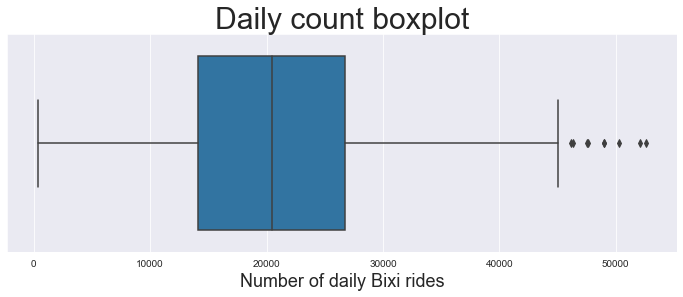

In [36]:
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = 12,4

count_boxplot = sns.boxplot(x=main_df_cleaned_active['DAILY_COUNT'])
count_boxplot.set_title('Daily count boxplot', fontsize= 30)
count_boxplot.set_xlabel('Number of daily Bixi rides', fontsize = 18)
plt.show()

The Daily Count boxplot is quite symetric other than a few outliers to the right. The 2nd and 3rd quartile are noticably smaller than the 1rst and 4rth. So we can say tht 50% of the days, there is between 14000 and 26000 daily rides.


In [37]:
# Let's look at more statistics of the DAILY_COUNT
main_df_cleaned_active['DAILY_COUNT'].describe()

count     1767.000000
mean     20724.680249
std       9016.793032
min        334.000000
25%      14086.000000
50%      20489.000000
75%      26707.000000
max      52630.000000
Name: DAILY_COUNT, dtype: float64

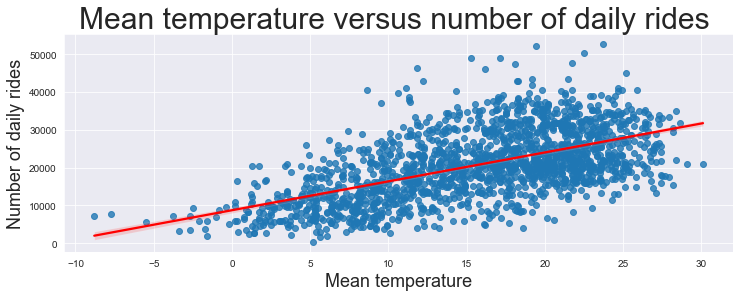

In [38]:
temp_scatter = sns.regplot(data=main_df_cleaned_active, x="MEAN_TEMP", y="DAILY_COUNT", line_kws={"color": "red"})
plt.rcParams['figure.figsize'] = 12,10
temp_scatter.set_title('Mean temperature versus number of daily rides ', fontsize= 30)
temp_scatter.set_xlabel('Mean temperature', fontsize = 18)
temp_scatter.set_ylabel('Number of daily rides', fontsize = 18)

plt.show()


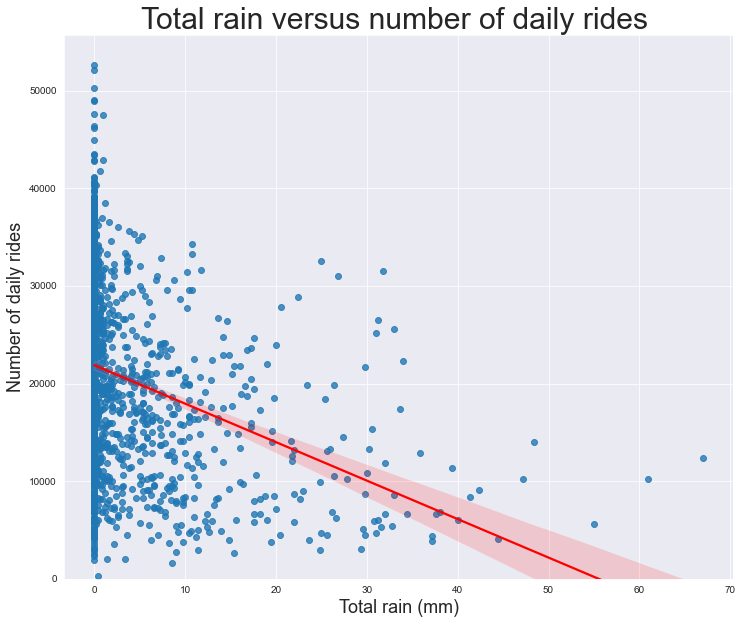

In [39]:
rain_dist = sns.regplot(data=main_df_cleaned_active, x="TOTAL_RAIN", y="DAILY_COUNT", line_kws={"color": "red"})
plt.rcParams['figure.figsize'] = 12,10
rain_dist.set_title('Total rain versus number of daily rides ', fontsize= 30)
rain_dist.set_xlabel('Total rain (mm)', fontsize = 18)
rain_dist.set_ylabel('Number of daily rides', fontsize = 18)
rain_dist.set(ylim=(0, None))
plt.show()

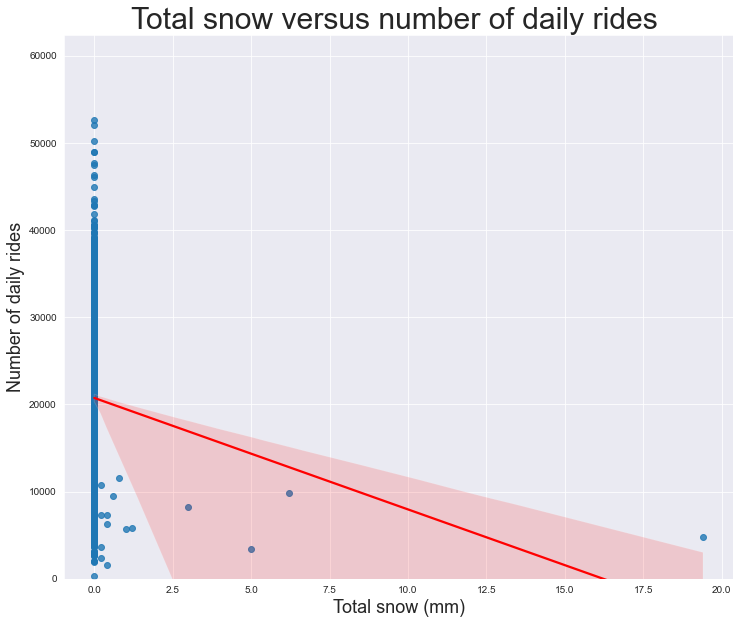

In [40]:
rain_dist = sns.regplot(data=main_df_cleaned_active, x="TOTAL_SNOW", y="DAILY_COUNT", line_kws={"color": "red"})
plt.rcParams['figure.figsize'] = 12,10
rain_dist.set_title('Total snow versus number of daily rides ', fontsize= 30)
rain_dist.set_xlabel('Total snow (mm)', fontsize = 18)
rain_dist.set_ylabel('Number of daily rides', fontsize = 18)
rain_dist.set(ylim=(0, None))
plt.show()

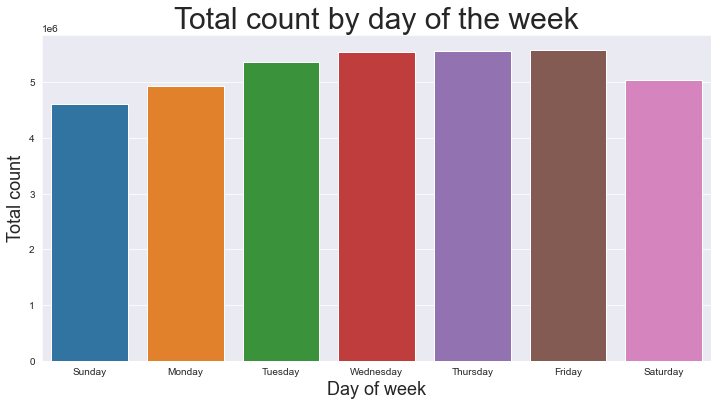

In [41]:
main_df_cleaned_active_day = main_df_cleaned_active.copy()
main_df_cleaned_active_day = main_df_cleaned_active_day.drop(columns=['MEAN_TEMP', 'TOTAL_RAIN', 'TOTAL_SNOW'])
main_df_cleaned_active_day.rename(columns = {'DATE':'DAY', 'DAILY_COUNT':'TOTAL_COUNT'}, inplace = True)
main_df_cleaned_active_day['DAY'] = pd.to_datetime(main_df_cleaned_active_day['DAY'])
main_df_cleaned_active_day['DAY'] = main_df_cleaned_active_day['DAY'].dt.day_name()
main_df_cleaned_active_day = main_df_cleaned_active_day.groupby(['DAY']).sum()

plt.rcParams['figure.figsize'] = 12,6
total_by_day = sns.barplot(x = main_df_cleaned_active_day.index, y = main_df_cleaned_active_day['TOTAL_COUNT'].values, order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
total_by_day.set_title('Total count by day of the week', fontsize= 30)
total_by_day.set_xlabel('Day of week', fontsize = 18)
total_by_day.set_ylabel('Total count', fontsize = 18)
plt.show()

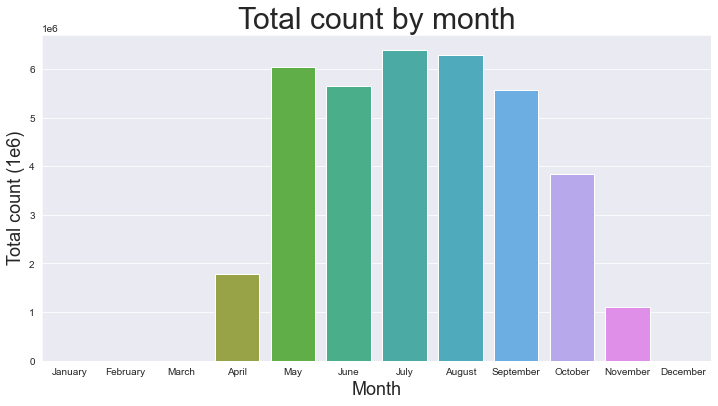

In [42]:
main_df_cleaned_month = main_df_cleaned.copy()
main_df_cleaned_month = main_df_cleaned_month.drop(columns=['MEAN_TEMP', 'TOTAL_RAIN', 'TOTAL_SNOW'])
main_df_cleaned_month.rename(columns = {'DATE':'MONTH', 'DAILY_COUNT':'TOTAL_COUNT'}, inplace = True)
main_df_cleaned_month['MONTH'] = pd.to_datetime(main_df_cleaned_month['MONTH'])
main_df_cleaned_month['MONTH'] = main_df_cleaned_month['MONTH'].dt.month_name()
main_df_cleaned_month = main_df_cleaned_month.groupby(['MONTH']).sum()
main_df_cleaned_month

plt.rcParams['figure.figsize'] = 12,6
total_by_month = sns.barplot(x = main_df_cleaned_month.index, y = main_df_cleaned_month['TOTAL_COUNT'].values, order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
total_by_month.set_title('Total count by month', fontsize= 30)
total_by_month.set_xlabel('Month', fontsize = 18)
total_by_month.set_ylabel('Total count (1e6)', fontsize = 18)
plt.show()

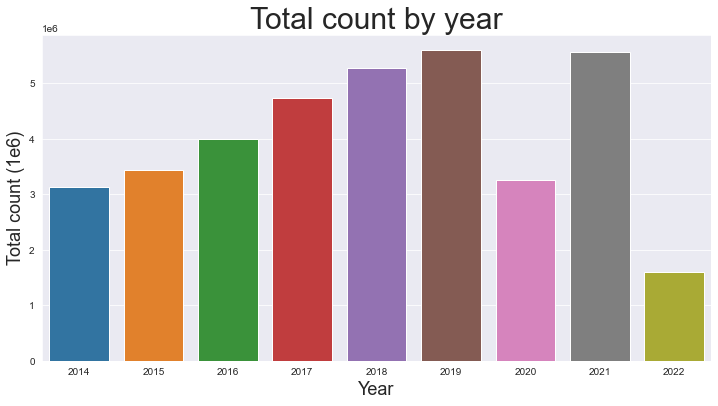

In [43]:
main_df_cleaned_year = main_df_cleaned.copy()
main_df_cleaned_year = main_df_cleaned_year.drop(columns=['MEAN_TEMP', 'TOTAL_RAIN', 'TOTAL_SNOW'])
main_df_cleaned_year.rename(columns = {'DATE':'YEAR', 'DAILY_COUNT':'TOTAL_COUNT'}, inplace = True)
main_df_cleaned_year['YEAR'] = pd.DatetimeIndex(main_df_cleaned_year['YEAR']).year
main_df_cleaned_year = main_df_cleaned_year.groupby(['YEAR']).sum()

plt.rcParams['figure.figsize'] = 12,6
total_by_year = sns.barplot(x = main_df_cleaned_year.index, y = main_df_cleaned_year['TOTAL_COUNT'].values, order=list(range(2014, 2023)))
total_by_year.set_title('Total count by year', fontsize= 30)
total_by_year.set_xlabel('Year', fontsize = 18)
total_by_year.set_ylabel('Total count (1e6)', fontsize = 18)
plt.show()

### Observations
- The daily count boxplot reveals that the datset is very symetric. The quartiles show that 50% of the daily rides throught the year is between 14000 and 26000.
- The most Bixi rides in a single day reached over 52000 rides.
- There seems to be a positive correlation between the daily weather and the total rides. That being said, there is high variance.
- There seems to be a negative correlation between the total rainfall and the total rides. 
- There is probably a negative correlation between snowfall and total rides. That being said, the dataset is highly skewed towards days with 0mm of snowfall. This is to be expected since the Bixi service is not offered during the winter months in Montreal. Therefore, there might not be enough datapoints to conclude a precise correlation.
- Days of the week were somewhat surprising. Sunday is the least popular day while Wednesday, Thursday and Friday are neck and neck for the most popular day.
- Months of the year show a bigger difference than days of the week. April and November are the least popular. That being said, Bixi's service is only offered for half of those months. December to March there are no rides since the service is not offered. Lastly, October is the least popular month the has the service running all month.
- As for year to year, there is a pretty clear increase since 2014. Because of Covid, 2020 dropped by almost 50% the previous year's usage. The year 2021 almost caught up with 2019's popularity. It is quite good considering that the province of Québec had some restrictions due to covid and work from home was heavily suggested by the provincial government.
- We are in the middle of 2022 and so data is still coming in. It seems to be back to it's pre-covid popularity.

## 6 - Model Building

To build a linear regression model, the Date column as it is will not work. I need to extract the relevant information from it like the day of week, the month and the year. We already did this in alternate dataframes in the analysis section.

In [44]:
# Let's build a df with days, months and years. 
main_test_train_df = main_df_cleaned.copy()
main_test_train_df['MONTH'] = pd.DatetimeIndex(main_test_train_df['DATE']).month
main_test_train_df['DAY'] = pd.DatetimeIndex(main_test_train_df['DATE']).day
main_test_train_df['DATE'] = pd.DatetimeIndex(main_test_train_df['DATE']).year
main_test_train_df.rename(columns = {'DATE':'YEAR'}, inplace = True)
main_test_train_df.tail()


,YEAR,DAILY_COUNT,MEAN_TEMP,TOTAL_RAIN,TOTAL_SNOW,MONTH,DAY
2964,2022,26532,19.1,31.2,0.0,5,27
2965,2022,47495,18.1,1.0,0.0,5,28
2966,2022,52075,19.4,0.0,0.0,5,29
2967,2022,43544,21.5,0.0,0.0,5,30
2968,2022,46155,16.2,0.0,0.0,5,31


In [45]:
# Y = main_test_train_df['DAILY_COUNT']
Y = pd.DataFrame(main_test_train_df['DAILY_COUNT'])
X = main_test_train_df.drop(columns=['DAILY_COUNT'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [46]:
# Train our model
LR = LinearRegression()
LR.fit(X_train.values, Y_train.values)

LinearRegression()

In [47]:
# test the model
prediction = LR.predict(X_test.values)
LR.score(X_test.values, Y_test.values)

0.743537509194932

In [48]:
# Since I am new to data science, I am not sure how to interpret a score of 0.7. Is it any good?
# Let's bring in June's weather data and predict for each day. Then, test with the real bixi data and see whatcomes out.
# First, convert the .csv weather to a dataframe of the correct format.
june_weather_test_csv = pd.read_csv('june2022-weather.csv')
june_test_df = june_weather_test_csv.copy()
june_test_df = june_test_df.drop(columns=['SPD_OF_MAX_GUST'])
june_test_df['MONTH'] = pd.DatetimeIndex(june_test_df['DATE']).month
june_test_df['DAY'] = pd.DatetimeIndex(june_test_df['DATE']).day
june_test_df['DATE'] = pd.DatetimeIndex(june_test_df['DATE']).year
june_test_df.rename(columns = {'DATE':'YEAR'}, inplace = True)
june_test_df.head()


,YEAR,MEAN_TEMP,TOTAL_RAIN,TOTAL_SNOW,MONTH,DAY
0,2022,15.4,1.8,0.0,6,1
1,2022,16.6,0.0,0.0,6,2
2,2022,20.1,0.8,0.0,6,3
3,2022,17.3,0.0,0.0,6,4
4,2022,15.4,0.0,0.0,6,5


In [49]:
# These are the prediction of daily cout of bixi rides for June 2022 
june_prediction = LR.predict(june_test_df.values)

In [50]:
# Since I am new to data science, I am not sure how to interpret a score of 0.7. Is it any good?
# Let's bring in June's weather data and predict for each day. Then, test with the real bixi data and see whatcomes out.
# First, convert the .csv weather to a dataframe of the correct format.
june_bixi_test_csv = pd.read_csv('june2022-bixi.csv')
june_result_df = june_bixi_test_csv.copy()
june_result_df['DAY'] = pd.DatetimeIndex(june_result_df['start_date']).day
june_result_df = june_result_df.drop(columns=['start_date','emplacement_pk_start', 'end_date','emplacement_pk_end','duration_sec','is_member'])
june_result_df = june_result_df['DAY'].value_counts()

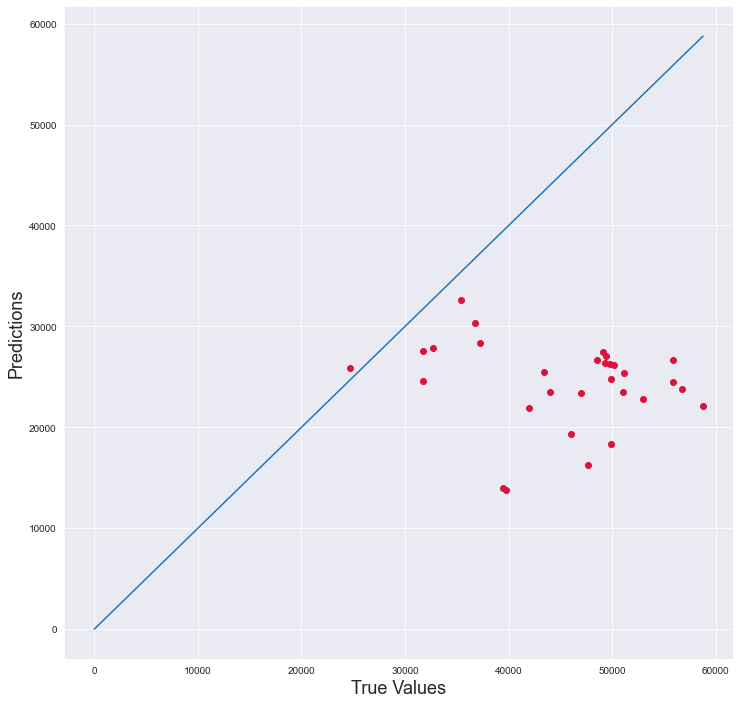

In [51]:
plt.rcParams['figure.figsize'] = 12,12
plt.scatter(june_result_df, june_prediction, c='crimson')

p1 = max(max(june_prediction), max(june_result_df))
p2 = min(min(june_prediction), min(june_result_df))
plt.plot([p1, 0], [p1, 0])
plt.xlabel('True Values', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.show()

## 7 - Conclusion

My model got a score of 0.74 with R^2 score test. I have no frame of reference on this value but it doesn't sound too bad for this use case. That being said, Predicting the daily rides of June 2022 was somewhat of a disaster. Let's dissect this a little bit:

- June 2022 has been the most popular month of June in Bixi's history
- I trained and tested my model with winter months included. I should test it without them to see if that has a positive impact (winter months have 0 users since the service is not offered.)
- I have only partial data for 2022. Everymonth of 2022 is beeting previous records.
- Years 2020 and 2021 were impacted by the health measures imposed by the Quebec government. Somehow reducing the weight of those years while training the model might lead to better results.

Overall I am quite happy with the outcome. This has been my first time using Python, pandas, seaborn, Jupyter notebooks, SQL, Google Big Query and beautiful Soup 4. I am definitely better prepared for the next project.

Thank you for reading! 😊